In [ ]:
import os
# import zipfile # Removed
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive # Added

# ==========================================
# 1. MOUNT GOOGLE DRIVE & KONFIGURASI PATH
# ==========================================
print("🔗 Menghubungkan ke Google Drive...")
drive.mount('/content/gdrive')

# Tentukan path ke folder dataset di Google Drive Anda.
# PASTIKAN nama folder ini sudah ada di 'My Drive' Anda
# atau Anda telah membuat shortcut dari folder yang dibagikan.
# Contoh: '/content/gdrive/MyDrive/NamaFolderDatasetAnda'
base_dir = '/content/gdrive/MyDrive/jeruk_3_final' # Sesuaikan dengan nama folder di Drive Anda
# Jika ada subfolder di dalam folder ini yang berisi kelas-kelasnya, misalnya:
# '/content/gdrive/MyDrive/JERUK 3 JENIS FINAL (1059)/data_citrus/LIMAU FINAL'
# maka base_dir harus disesuaikan: '/content/gdrive/MyDrive/JERUK 3 JENIS FINAL (1059)/data_citrus'

# Cek apakah folder ditemukan
if not os.path.exists(base_dir):
    print(f"❌ ERROR: Folder '{base_dir}' tidak ditemukan di Google Drive Anda.")
    print("Pastikan Anda sudah me-mount Google Drive dan path folder sudah benar.")
    # Anda bisa menghentikan eksekusi di sini jika folder tidak ditemukan
else:
    print(f"✅ Folder dataset ditemukan di: {base_dir}")
    print(f"📂 Isi directory aktif: {os.listdir(base_dir)}")

# ==========================================
# 3. DATA GENERATOR & AUGMENTASI
# ==========================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2
)

print("\n🔄 Memuat Data Training & Validasi...")

# Training Generator
train_generator = train_datagen.flow_from_directory(
    base_dir,                 # Path yang sudah otomatis benar
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', # Wajib Categorical
    subset='training',
    shuffle=True
)

# Validation Generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# ==========================================
# 4. LAPORAN LABEL
# ==========================================
print("\n🎯 HASIL MAPPING KELAS:")
labels = train_generator.class_indices
print(labels)
print(f"Total Kelas: {len(labels)}")

if len(labels) == 3:
    print("✅ STATUS: SIAP TRAINING! (3 Kelas terdeteksi)")
else:
    print("⚠️ WARNING: Jumlah kelas bukan 3. Cek struktur folder lagi.")

🔗 Menghubungkan ke Google Drive...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✅ Folder dataset ditemukan di: /content/gdrive/MyDrive/jeruk_3_final
📂 Isi directory aktif: ['jeruk_nipis', 'jeruk_purut', 'jeruk_limau']

🔄 Memuat Data Training & Validasi...
Found 804 images belonging to 3 classes.
Found 198 images belonging to 3 classes.

🎯 HASIL MAPPING KELAS:
{'jeruk_limau': 0, 'jeruk_nipis': 1, 'jeruk_purut': 2}
Total Kelas: 3
✅ STATUS: SIAP TRAINING! (3 Kelas terdeteksi)


In [ ]:
import tensorflow as tf

# ==========================================
# 5. ARSITEKTUR MODEL (CNN)
# ==========================================
# Kita gunakan 4 layer Konvolusi karena tekstur jeruk (pori-pori kulit)
# butuh fitur yang cukup detail untuk dibedakan.
model = tf.keras.models.Sequential([
    # --- Feature Extraction Layer (Mata-nya Model) ---
    # Layer 1: Deteksi fitur dasar (garis, lengkungan)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 2: Deteksi tekstur kasar
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Layer 3: Deteksi pola kulit spesifik
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Layer 4: Memperdalam pemahaman fitur kompleks
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # --- Classification Layer (Otak-nya Model) ---
    tf.keras.layers.Flatten(),                  # Ubah gambar jadi data deret
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),               # Matikan 50% neuron biar gak "menghafal" (Overfitting)

    # Output Layer: 3 Node (Limau, Nipis, Purut)
    # Gunakan 'softmax' untuk probabilitas multi-kelas
    tf.keras.layers.Dense(3, activation='softmax')
])

# Cek ringkasan model (Opsional, biar kelihatan keren di laporan)
model.summary()

# ==========================================
# 6. KOMPILASI MODEL
# ==========================================
model.compile(
    loss='categorical_crossentropy', # Wajib ini karena data kita 3 kategori
    optimizer='adam',                # Optimizer paling standar & ampuh
    metrics=['accuracy']
)

# ==========================================
# 7. PROSES TRAINING (FIT)
# ==========================================
print("\n🚀 Mulai Training... Siapkan kopi, ini butuh waktu sedikit.")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32, # Hitung otomatis langkah per epoch
    epochs=20,                                     # Jumlah putaran belajar
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    verbose=1
)

print("\n✅ Training Selesai!")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Mulai Training... Siapkan kopi, ini butuh waktu sedikit.
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3805 - loss: 1.1083 - val_accuracy: 0.4115 - val_loss: 1.0776
Epoch 2/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3750 - loss: 1.0680

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3750 - loss: 1.0680 - val_accuracy: 0.3646 - val_loss: 1.0726
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.3833 - loss: 1.0797 - val_accuracy: 0.5469 - val_loss: 0.9733
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3750 - loss: 1.0618 - val_accuracy: 0.5625 - val_loss: 0.9730
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.5136 - loss: 0.9952 - val_accuracy: 0.5469 - val_loss: 0.9889
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5625 - loss: 0.9931 - val_accuracy: 0.5312 - val_loss: 0.9950
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.5355 - loss: 0.9630 - val_accuracy: 0.5312 - val_loss: 0.8643
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6250 - loss: 0.8828 - val_accuracy: 0.5208 - val_loss: 0.8860
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.5836 - loss: 0.8838 - val_accuracy: 0.5312 - val_los

📋 Daftar Kelas yang dikenali model: ['jeruk_limau', 'jeruk_nipis', 'jeruk_purut']

📤 Silakan upload file gambar jeruk (Limau/Nipis/Purut) untuk dites:


Saving afcbandung_buah_jeruk_limau_jeruk_limo_untuk_sambal_500gr_full02_s32bpi7w.jpg to afcbandung_buah_jeruk_limau_jeruk_limo_untuk_sambal_500gr_full02_s32bpi7w.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


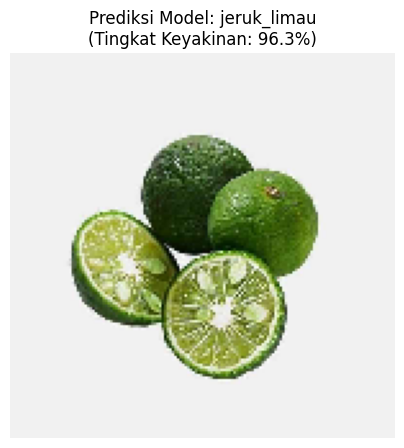


📊 Analisis Probabilitas untuk 'afcbandung_buah_jeruk_limau_jeruk_limo_untuk_sambal_500gr_full02_s32bpi7w.jpg':


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# ==========================================
# 9. PERSIAPAN LABEL KELAS
# ==========================================
# Mengambil nama kelas langsung dari generator agar urutannya 100% akurat
labels_list = list(train_generator.class_indices.keys())
print("📋 Daftar Kelas yang dikenali model:", labels_list)

# ==========================================
# 10. UPLOAD & PREDIKSI GAMBAR
# ==========================================
print("\n📤 Silakan upload file gambar jeruk (Limau/Nipis/Purut) untuk dites:")
uploaded = files.upload()

for fn in uploaded.keys():
    # --- A. Preprocessing (Wajib sama dengan saat Training) ---
    path = fn
    # Load gambar & ubah ukuran ke 150x150 (sesuai input model)
    img = load_img(path, target_size=(150, 150))

    # Ubah gambar ke Array Numpy
    x = img_to_array(img)

    # Tambah dimensi batch: dari (150, 150, 3) jadi (1, 150, 150, 3)
    x = np.expand_dims(x, axis=0)

    # Normalisasi piksel (0-255 jadi 0-1)
    # ⚠️ PENTING: Tanpa ini, hasil prediksi pasti ngaco!
    x = x / 255.0

    # --- B. Proses Prediksi ---
    classes = model.predict(x, batch_size=10)

    # Ambil index dengan probabilitas tertinggi
    predicted_index = np.argmax(classes)
    final_label = labels_list[predicted_index]
    confidence = np.max(classes) * 100 # Persentase keyakinan

    # --- C. Visualisasi Hasil ---
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off') # Hilangkan sumbu X/Y biar rapi

    # Judul gambar dengan hasil prediksi
    plt.title(f"Prediksi Model: {final_label}\n(Tingkat Keyakinan: {confidence:.1f}%)")
    plt.show()

    # --- D. Laporan Detail Probabilitas (Untuk Analisis) ---
    print(f"\n📊 Analisis Probabilitas untuk '{fn}':")
    for i, label in enumerate(labels_list):
        score = classes[0][i] * 100
        # Tanda panah (

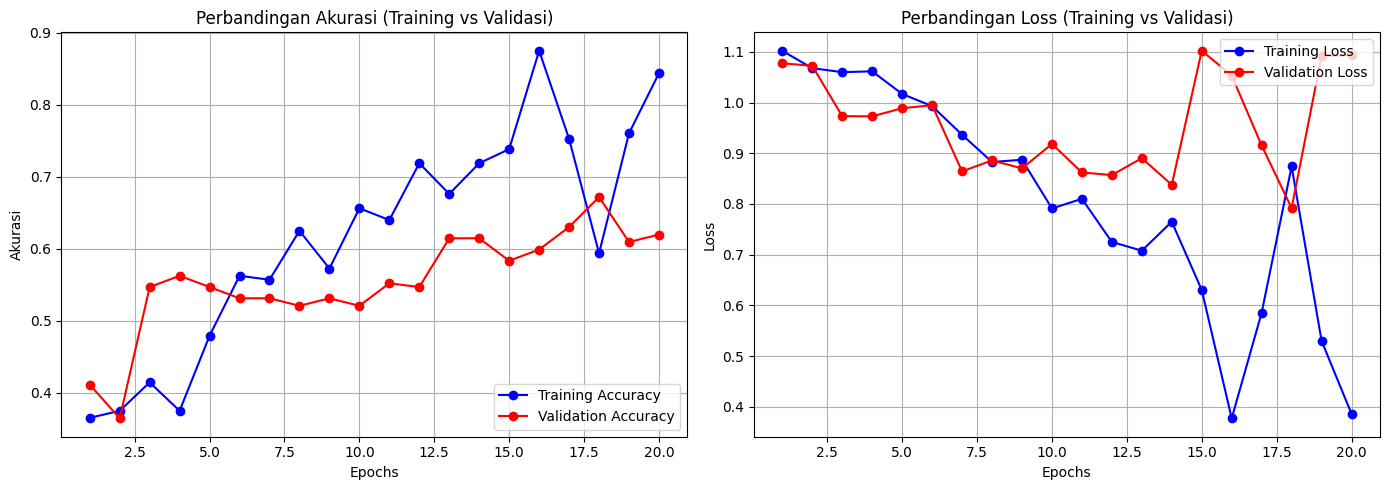

In [ ]:
import matplotlib.pyplot as plt

# ==========================================
# 8. VISUALISASI HASIL TRAINING (GRAFIK)
# ==========================================

# Mengambil nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat range epoch (1 sampai 20)
epochs_range = range(1, len(acc) + 1)

# Mengatur ukuran canvas gambar
plt.figure(figsize=(14, 5))

# --- GRAFIK 1: AKURASI (Training vs Validation) ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy') # Garis Biru
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy') # Garis Merah
plt.title('Perbandingan Akurasi (Training vs Validasi)')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.grid(True)

# --- GRAFIK 2: LOSS (Training vs Validation) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss') # Garis Biru
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss') # Garis Merah
plt.title('Perbandingan Loss (Training vs Validasi)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 8b. EVALUASI AKHIR PADA DATA TESTING (VALIDASI)
# ==========================================
print("\n📊 Menghitung Akurasi Final pada Data Validasi/Test...")

# Evaluasi model menggunakan data validasi
test_loss, test_acc = model.evaluate(validation_generator, verbose=1)

print(f"\n🏆 Hasil Akhir:")
print(f"   - Loss     : {test_loss:.4f}")
print(f"   - Accuracy : {test_acc * 100:.2f}%")

# Grade otomatis untuk laporan
if test_acc >= 0.85:
    print("   - Predikat : SANGAT BAIK (A)")
elif test_acc >= 0.70:
    print("   - Predikat : BAIK (B)")
else:
    print("   - Predikat : PERLU PERBAIKAN (C)")


📊 Menghitung Akurasi Final pada Data Validasi/Test...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.6023 - loss: 1.1090

🏆 Hasil Akhir:
   - Loss     : 1.1088
   - Accuracy : 61.11%
   - Predikat : PERLU PERBAIKAN (C)


Found 198 images belonging to 3 classes.

🔍 Sedang memprediksi seluruh data test...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step

📋 Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

 jeruk_limau       0.53      0.26      0.35        66
 jeruk_nipis       0.62      0.91      0.74        66
 jeruk_purut       0.64      0.67      0.65        66

    accuracy                           0.61       198
   macro avg       0.60      0.61      0.58       198
weighted avg       0.60      0.61      0.58       198



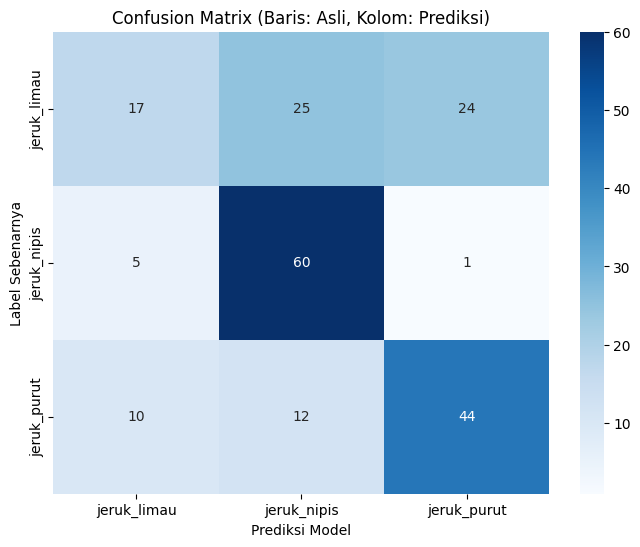

In [ ]:
# ==========================================
# 8b. ANALISIS MENDALAM (CONFUSION MATRIX)
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# 1. Kita buat Generator khusus Testing (Tanpa Shuffle/Acak)
# Agar prediksi urut dan bisa dibandingkan dengan label asli
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # Menggunakan data yang sama dengan validasi
    shuffle=False        # PENTING: Jangan diacak agar urutan label benar
)

# 2. Lakukan Prediksi
print("\n🔍 Sedang memprediksi seluruh data test...")
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1) # Ambil kelas dengan probabilitas tertinggi

# 3. Tampilkan Classification Report (Presisi, Recall, F1-Score)
class_labels = list(test_generator.class_indices.keys())
print("\n📋 Laporan Klasifikasi Rinci:")
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))

# 4. Tampilkan Confusion Matrix (Tabel Salah Tebak)
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Baris: Asli, Kolom: Prediksi)')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Prediksi Model')
plt.show()